In [1]:
# Chaitra Pirisingula
# Shruti Pradeep
# 04/10/2023 

In [2]:
from ColorBlindnessAnalysis import *
from ColorMasks import *
import cv2

In [3]:
cb_masks = [protanopia_simulation_matrix, deuteranopia_simulation_matrix, tritanopia_simulation_matrix]
cb_names = ["Protanopia", "Deuteranopia", "Tritanopia"]

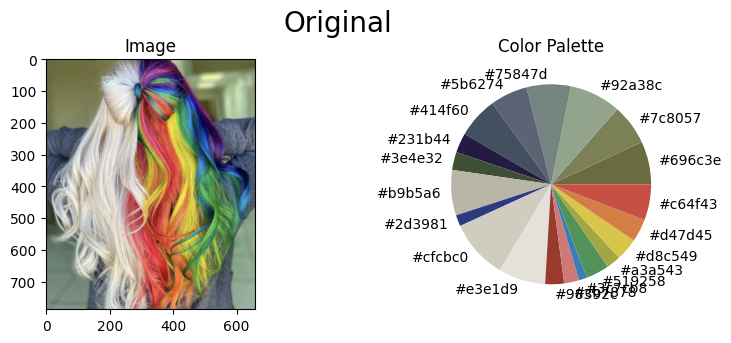

In [4]:
# Load original image
image = cv2.imread('images/rainbow_hair.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get original colors and corresponding colorblindness colors with delta e scores
original_colors = get_colors(image, 20, "Original")
cb_scores = get_color_similarity_scores(original_colors, cb_names, cb_masks)

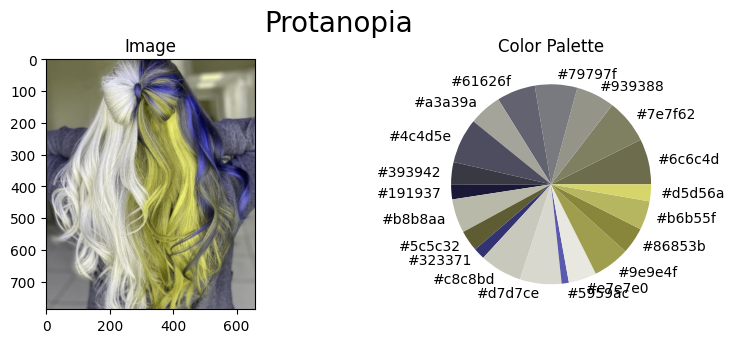

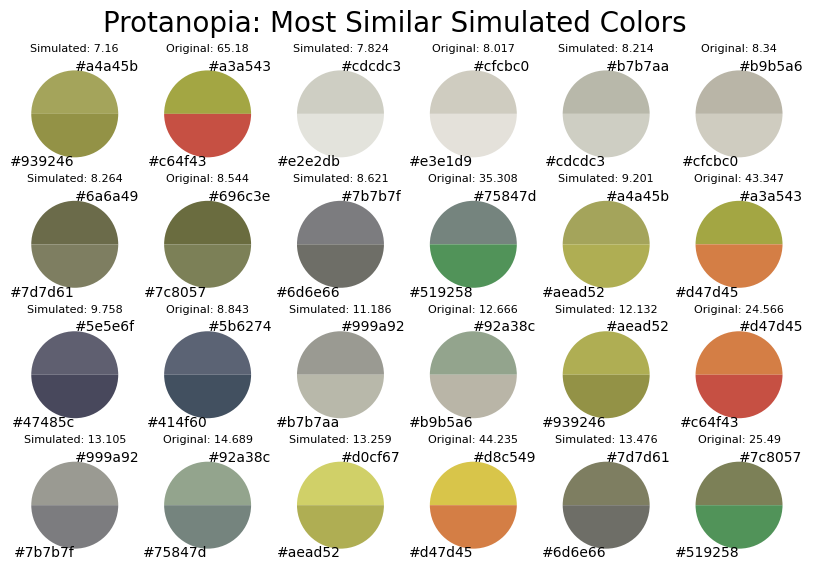

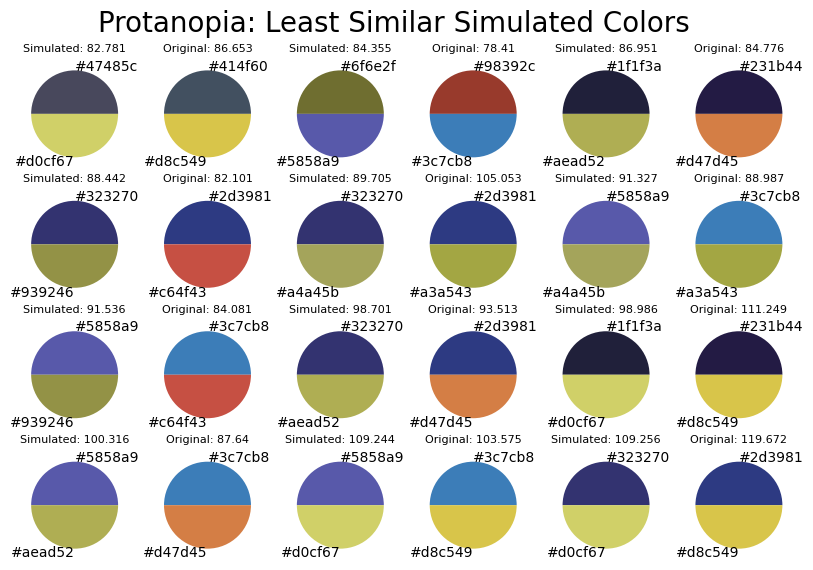

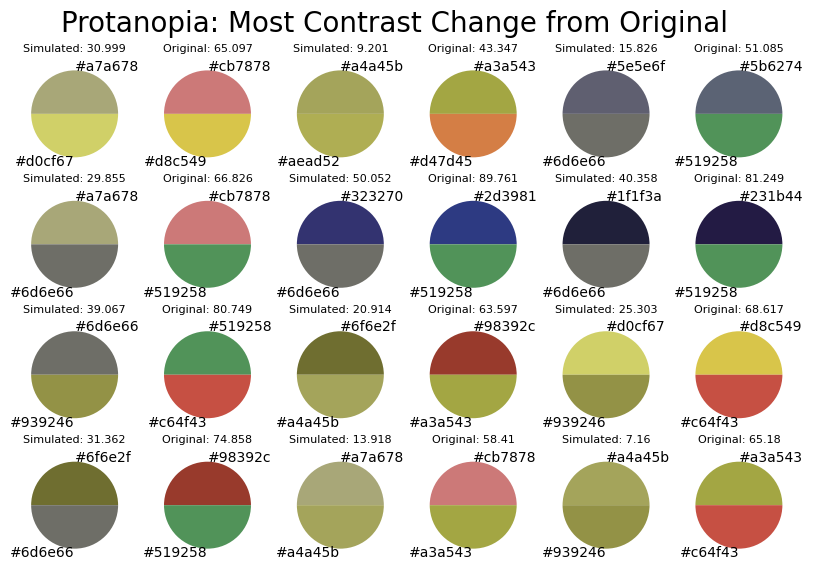

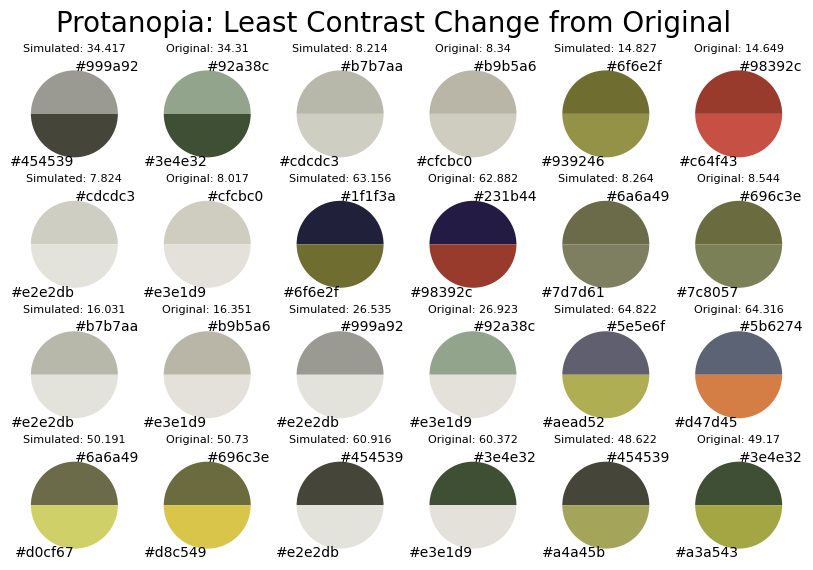

In [5]:
# Simulate Protanopia and display results 
protanopia_image = simulate_colorblindness(protanopia_simulation_matrix, image)
protanopia_colors = get_colors(protanopia_image, 20, cb_names[0])
display_charts(cb_names[0], cb_scores[cb_names[0]])

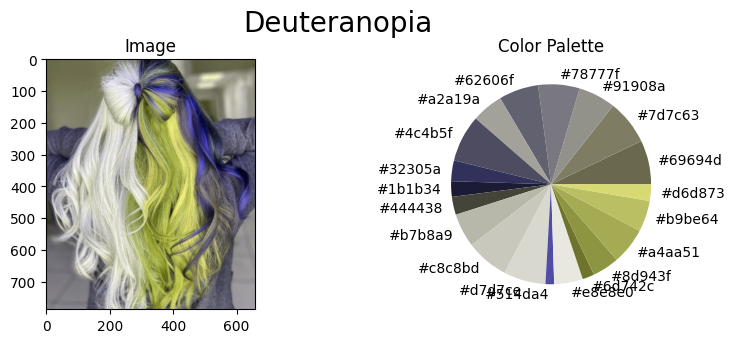

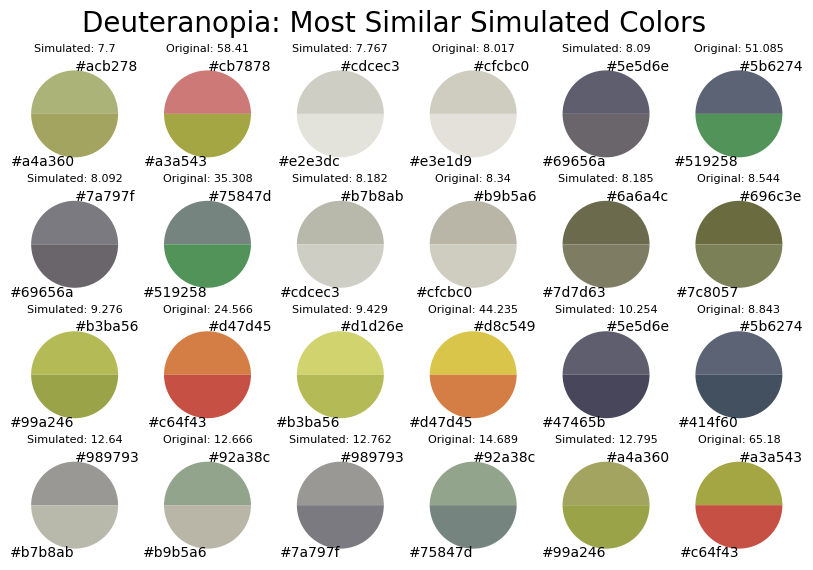

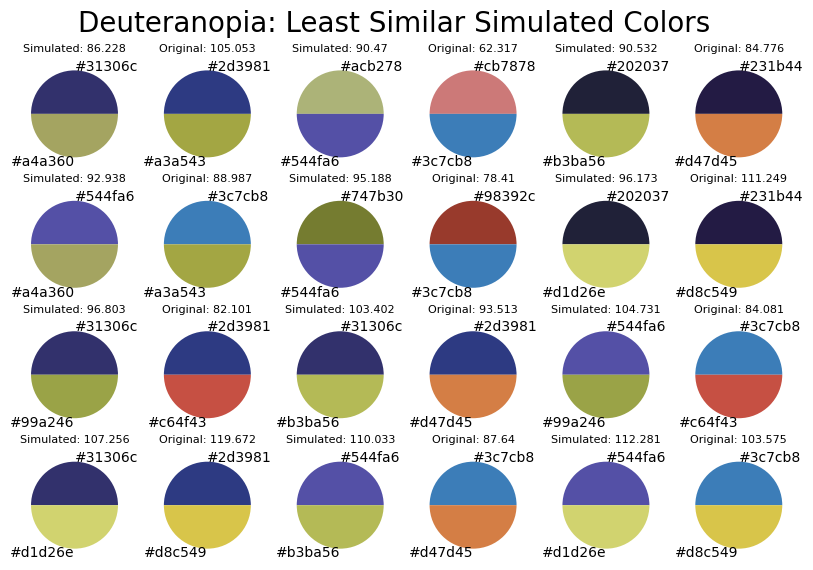

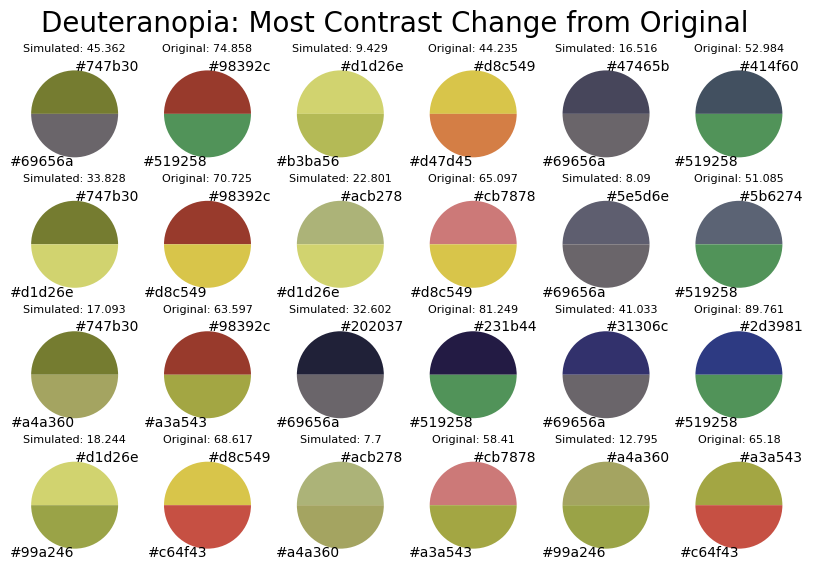

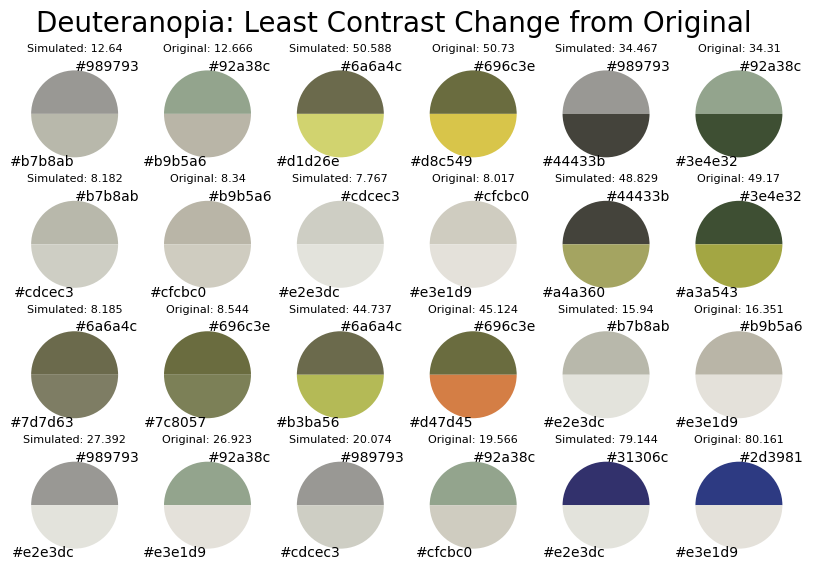

In [6]:
# Simulate Deuteranopia and display results 
deuteranopia_image = simulate_colorblindness(deuteranopia_simulation_matrix, image)
deuteranopia_colors = get_colors(deuteranopia_image, 20, cb_names[1])
display_charts(cb_names[1], cb_scores[cb_names[1]])

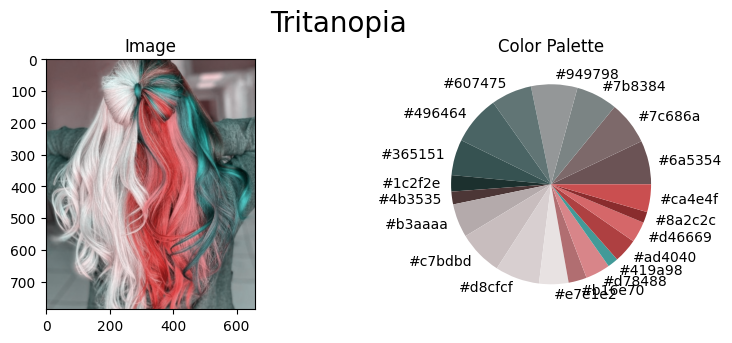

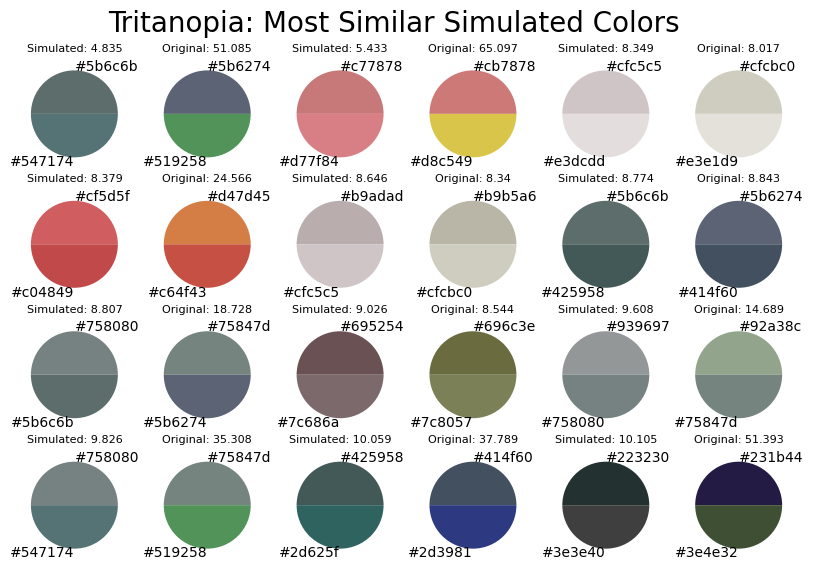

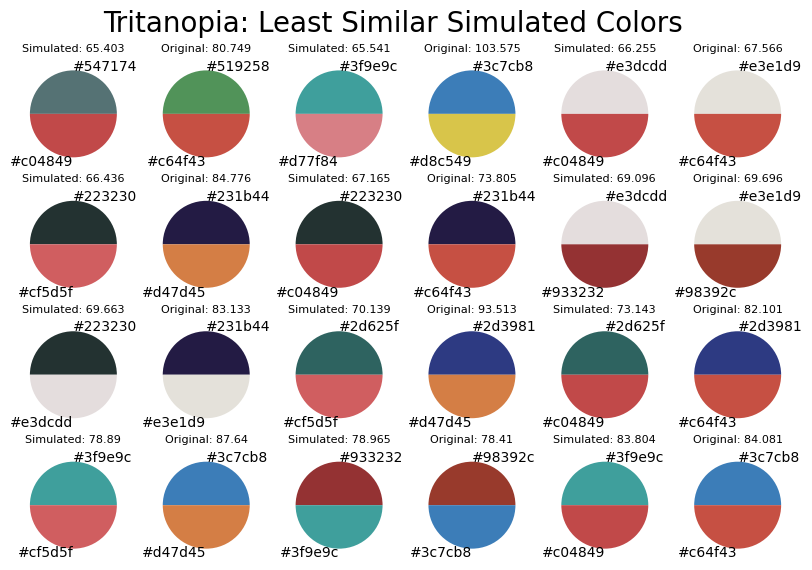

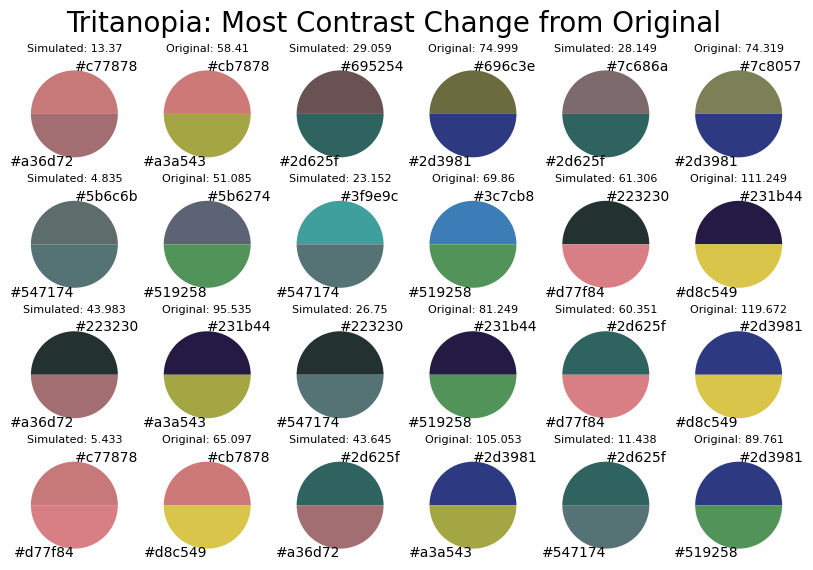

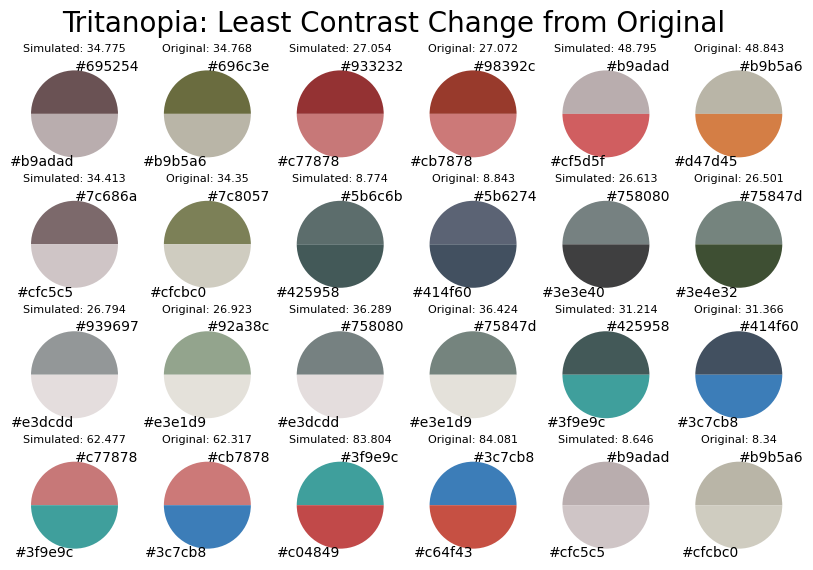

In [7]:
# Simulate Tritanopia and display results 
tritanopia_image = simulate_colorblindness(tritanopia_simulation_matrix, image)
tritanopia_colors = get_colors(tritanopia_image, 20, cb_names[2])
display_charts(cb_names[2], cb_scores[cb_names[2]])